In [1]:
import h5py as hp
import matplotlib.pyplot as plt
import numpy as np
import illustris_python as il
import matplotlib.gridspec as gspec
import matplotlib as mpl
import copy
from hc_lib.plots.fig_lib import FigureLibrary

In [28]:
import os

class ResultContainer():
    
    def __init__(self, values, props):
        self.values = values
        self.props = props
        return
    
class ResultLibrary():

    def __init__(self, result_type):

        
        self.rt = result_type
        self.rcs = []
        self.paths = []

        return
    
    def addAllOutputPaths(self, output_dir, result_type):
        self.paths = []
        for (root, dirs, files) in os.walk(output_dir):
            for fl in files:
                filepath = os.path.join(root, fl)
                if '.hdf5' in filepath and 'results' in filepath:
                    self.addPath(filepath)
        return
    def addPath(self, path):
        self.paths.append(path)
        return
    
    def loadFile(self, runname):
        
        for p in self.paths:
            rt_in_file_path = p.split('_')[-1].split('.')[0]
            if runname in p and self.rt == rt_in_file_path:
                print(p)
                try:
                    f = hp.File(p, 'r')
                    for k in list(f.keys()):
                        self.rcs.append(ResultContainer(f[k][:], dict(f[k].attrs)))
#                         self.datasets.append(f[k][:])
#                         self.dprops.append(dict(f[k].attrs))
                    f.close()
                except BaseException:
                    print('exception with %s'%p)
                
        
        return
    
    def isMatch(self, dataset_props, desired_props):
        isMatch = True
        for k,v in desired_props.items():
            try:
                self_val = dataset_props[k]
            except KeyError:
                #print('did not find %s in dataset'%k)
                continue
            else:
#                 print(isinstance(self_val,list))
#                 print(type(self_val))

                # if we don't have a list of desired values, check if the property
                # of the result has the the desired value. Auto powers only have one
                # property to check
                if not isinstance(v, list) and not isinstance(self_val, np.ndarray):
                    isMatch = (isMatch and v == self_val)
                # if we do have a list of desired values, but the result is still an
                # auto power spectrum, check if self_val is in v
                elif isinstance(v, list) and not isinstance(self_val, np.ndarray):
                    isMatch = (isMatch and self_val in v)

                # if both are lists, we need to know if at least one value from self_val
                # is in the desired properties
                elif isinstance(v, list) and isinstance(self_val, np.ndarray):
                    one_val = False
                    for i in range(len(self_val)):
                        if self_val[i] in v:
                            one_val = True
                    isMatch = (isMatch and one_val)
                # the last case where v is not a list but self_val is
                elif not isinstance(v, list) and isinstance(self_val, np.ndarray):
                    isMatch = (isMatch and v in self_val)
                else:
                    print('not all cases handled')
        return isMatch
    
    def loadResults(self, iprops, rmprops):

        results = []
        props = []
        for residx in range(len(self.rcs)):
            is_include = self.isMatch(self.rcs[residx].props, iprops)
            is_remove = self.isMatch(self.rcs[residx].props, rmprops)
            if is_include and not is_remove:
                results.append(self.rcs[residx])
        
        self.results = results
        return
    
    def getAllValuesOfProp(self, prop):
        values = set()
        for i in self.rcs:
            
            values.add(i.props[prop])
        return values
    
    def getResultValuesOfProp(self, prop):
        values = set()
        for i in self.results:
            
            values.add(i.props[prop])
        return values
    
    def organizeResults(self, rowp, rowvals, colp, colvals):
        nrows = len(rowvals)
        ncols = len(colvals)
        figArr = np.empty((nrows,ncols), dtype=object)
        
        for i in range(nrows):
            for j in range(ncols):
                panelResults = []
                for k in range(len(self.results)):
                    r = self.results[k]
                    rowval = rowvals[i]
                    colval = colvals[j]
                    if r.props[rowp] == rowval and r.props[colp] == colval:
                        panelResults.append(r)
                figArr[i,j] = panelResults
        return figArr

In [33]:
base = '/lustre/cosinga/hcolor/output/'
path = base + 'lowgr_tng100B_099S_0A_800R/results/hisubhalogrid_tng100B_099S_0A_800R_pks.hdf5'
#f = hp.File(path+'hisubhalogrid_tng100B_099S_0A_800R_pks.hdf5', 'r')
rlib = ResultLibrary('pks')
rlib.addPath(path)
rlib.loadFile('lowgr')

ip = {'fieldname':'hisubhalo'}
rmp = {'HI_res':'diemer'}
rlib.loadResults(ip, rmp)

/lustre/cosinga/hcolor/output/lowgr_tng100B_099S_0A_800R/results/hisubhalogrid_tng100B_099S_0A_800R_pks.hdf5


In [34]:
figarr = rlib.organizeResults('space', ['real', 'redshift'], 'snapshot', [99])

In [35]:
# rlib.getResultValuesOfProp('HI_res')
rcs = rlib.results
for r in rcs:
    print(r.props)


In [36]:
for r in rlib.rcs

0

In [7]:
def get_match(pkfile, props):
    keys = pkfile.keys()
    matches = []
    for k in keys:
        is_match = True
        
        for p,v in props.items():
            try:
                lval = pkfile[k].attrs[p]

                is_match = (is_match and v in lval)
            except KeyError:
                continue
        if is_match:
                matches.append(k)
    return matches

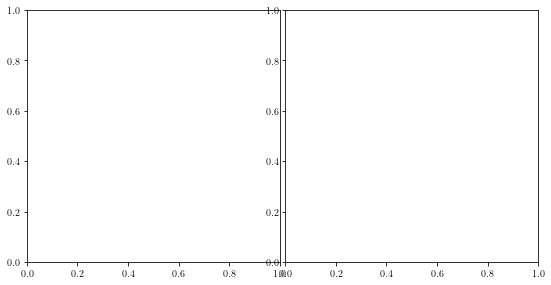

In [8]:
nrows = 1
ncols = 2
xborder = 1
yborder = 1
panel_bt = 0.1
panel_length = 3.5

# border input can be either a list or single number
if isinstance(xborder, float) or isinstance(xborder, int):
    xborder = [xborder, xborder]
if isinstance(yborder, float) or isinstance(yborder, int):
    yborder = [yborder, yborder]
if isinstance(panel_bt, float) or isinstance(panel_bt, int):
    panel_bt = [panel_bt, panel_bt]
# creating Figure object

figwidth = panel_length * ncols + panel_bt[0] * (ncols - 1) + \
        xborder[0] + xborder[1]
figheight = panel_length * nrows + panel_bt[1] * (nrows - 1) + \
        yborder[0] + yborder[1]

fig = plt.figure(figsize=(figwidth, figheight))

# creating gridspec
gs = gspec.GridSpec(nrows, ncols, left= xborder[0]/figwidth, right=1-xborder[1]/figwidth,
        top=1-yborder[1]/figheight, bottom=yborder[0]/figheight,
        wspace=panel_bt[0]*ncols/figwidth, hspace=panel_bt[1]*nrows/figheight)

# making panels list
panels = []
for i in range(nrows):
    col_panels = []
    for j in range(ncols):
        col_panels.append(fig.add_subplot(gs[i, j]))

    panels.append(col_panels)

flib = FigureLibrary(fig=fig, panels=panels)
flib.panel_length = panel_length
flib.panel_bt = panel_bt
flib.xborder = xborder
flib.yborder = yborder
flib.has_cbar_col = False
flib.figsize = [figwidth, figheight]

In [9]:
keys_for_panels = np.empty((nrows,ncols), dtype=object)

spaces = ['real', 'redshift']
for i in range(nrows):
    for j in range(ncols):
        props = {'space':spaces[j]}
        keys_for_panels[i,j] = get_match(f, props)

In [10]:
def _get_fill(keys, propname, propval):
    plot_pk = []
    for k in keys:
        if f[k].attrs[propname] == propval:
            arr = f[k]
            wn = arr[0,:]
            plot_pk.append(arr[1,:])
#             print(f[k].attrs['count'])
    return wn, np.array(plot_pk)
            
        
        
for i in range(nrows):
    for j in range(ncols):
        idx = (i,j)
        keys = keys_for_panels[idx]
        wn, pk = _get_fill(keys, 'HI_res','low-threshold')
        flib.plotFillPanel(idx, wn, pk, label = 'Low', color = 'lime')
        wn, pk = _get_fill(keys, 'HI_res','mid-threshold')
        flib.plotFillPanel(idx, wn, pk, label = 'Mid', color = 'cyan')
        wn, pk = _get_fill(keys, 'HI_res','high-threshold')
        flib.plotFillPanel(idx, wn, pk, label = 'High', color = 'salmon')
        

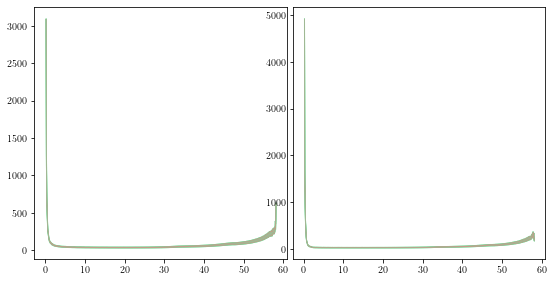

In [11]:
fig

In [12]:
box = f['0'].attrs['box']
mink = wn[0]
# axis
flib.logAxis()
flib.xLimAdjustToNyquist(gridres=800, box = box, xleft = mink)
flib.flushYAxisToData()
flib.matchAxisLimits()

# ticks
flib.changeTickDirection()
flib.removeDefaultTickLabels()

# labels
flib.addLegend()
flib.defaultAxesLabels()
flib.addColLabels(['Real-Space', 'Redshift-Space'], in_panel=True)

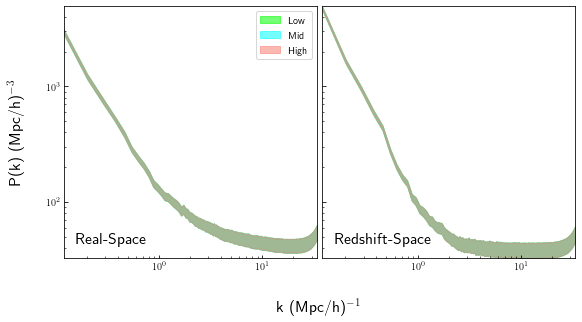

In [13]:
fig

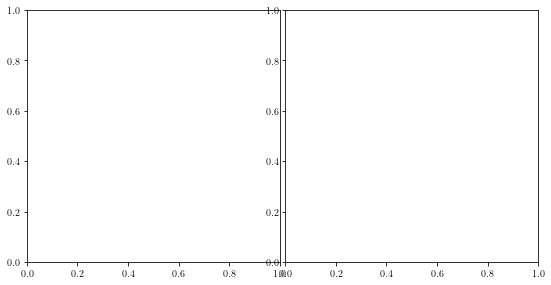

In [14]:
nrows = 1
ncols = 2
xborder = 1
yborder = 1
panel_bt = 0.1
panel_length = 3.5

# border input can be either a list or single number
if isinstance(xborder, float) or isinstance(xborder, int):
    xborder = [xborder, xborder]
if isinstance(yborder, float) or isinstance(yborder, int):
    yborder = [yborder, yborder]
if isinstance(panel_bt, float) or isinstance(panel_bt, int):
    panel_bt = [panel_bt, panel_bt]
# creating Figure object

figwidth = panel_length * ncols + panel_bt[0] * (ncols - 1) + \
        xborder[0] + xborder[1]
figheight = panel_length * nrows + panel_bt[1] * (nrows - 1) + \
        yborder[0] + yborder[1]

fig = plt.figure(figsize=(figwidth, figheight))

# creating gridspec
gs = gspec.GridSpec(nrows, ncols, left= xborder[0]/figwidth, right=1-xborder[1]/figwidth,
        top=1-yborder[1]/figheight, bottom=yborder[0]/figheight,
        wspace=panel_bt[0]*ncols/figwidth, hspace=panel_bt[1]*nrows/figheight)

# making panels list
panels = []
for i in range(nrows):
    col_panels = []
    for j in range(ncols):
        col_panels.append(fig.add_subplot(gs[i, j]))

    panels.append(col_panels)

flib = FigureLibrary(fig=fig, panels=panels)
flib.panel_length = panel_length
flib.panel_bt = panel_bt
flib.xborder = xborder
flib.yborder = yborder
flib.has_cbar_col = False
flib.figsize = [figwidth, figheight]

In [15]:
for i in range(nrows):
    for j in range(ncols):
        idx = (i,j)
        keys = keys_for_panels[idx]
        wn, pk = _get_fill(keys, 'HI_res','lowest-bin')
        flib.plotFillPanel(idx, wn, pk, label = 'Lowest', color = 'lime')
        wn, pk = _get_fill(keys, 'HI_res','low-bin')
        flib.plotFillPanel(idx, wn, pk, label = 'Low', color = 'plum')
        wn, pk = _get_fill(keys, 'HI_res','mid-bin')
        flib.plotFillPanel(idx, wn, pk, label = 'Mid', color = 'cyan')
        wn, pk = _get_fill(keys, 'HI_res','high-bin')
        flib.plotFillPanel(idx, wn, pk, label = 'High', color = 'salmon')
        

In [16]:
box = f['0'].attrs['box']
mink = wn[0]
# axis
flib.logAxis()
flib.xLimAdjustToNyquist(gridres=800, box = box, xleft = mink)
flib.flushYAxisToData()
flib.matchAxisLimits()

# ticks
flib.changeTickDirection()
flib.removeDefaultTickLabels()

# labels
flib.addLegend()
flib.defaultAxesLabels()
flib.addColLabels(['Real-Space', 'Redshift-Space'], in_panel=True)

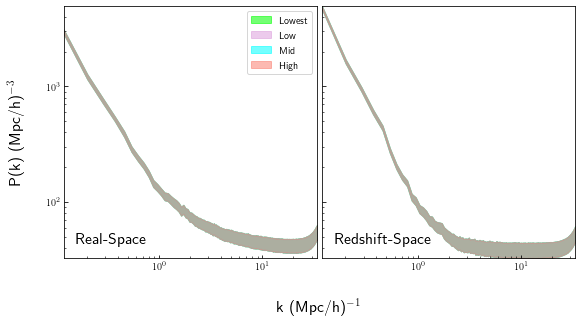

In [17]:
fig